In [4]:
from datasets import load_from_disk

babi_dataset = load_from_disk('data/')
print(babi_dataset['train'][0])

{'story': {'answer': ['', '', 'office'], 'id': ['1', '2', '3'], 'supporting_ids': [[], [], ['1']], 'text': ['The office is north of the kitchen.', 'The garden is south of the kitchen.', 'What is north of the kitchen?'], 'type': [0, 0, 1]}}


In [5]:
babi_dataset['train'][102]

{'story': {'answer': ['', '', 'bedroom'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['2']],
  'text': ['The bedroom is west of the office.',
   'The bedroom is east of the hallway.',
   'What is east of the hallway?'],
  'type': [0, 0, 1]}}

In [6]:
type_set = set()
for story in babi_dataset['train']:
    if str(story['story']['type']) not in type_set:
        type_set.add(str(story['story']['type']))

In [7]:
type_set

{'[0, 0, 1]'}

In [8]:
flattened_babi = babi_dataset.flatten()

In [9]:
flattened_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [10]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

In [11]:
def get_question_and_facts(story):
    dic = {}
    dic['question'] = story['story.text'][2]
    dic['sentences'] = ' '.join([story['story.text'][0], story['story.text'][1]])
    dic['answer'] = story['story.answer'][2]
    return dic

In [12]:
processed = flattened_babi.map(get_question_and_facts)

In [13]:
processed['train'][2]

{'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'answer': 'bedroom'}

In [14]:
processed['test'][2]

{'story.answer': ['', '', 'bathroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The bathroom is north of the garden.',
  'The hallway is north of the bathroom.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The bathroom is north of the garden. The hallway is north of the bathroom.',
 'answer': 'bathroom'}

In [15]:
def get_start_end_idx(story):
    str_idx = story['sentences'].find(story['answer'])
    end_idx = str_idx + len(story['answer'])
    return {'str_idx':str_idx,
          'end_idx': end_idx}

In [16]:
processed = processed.map(get_start_end_idx)

In [17]:
num = 187
print(processed['test'][num])
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('answer:', processed['test'][num]['sentences'][start_idx:end_idx])

{'story.answer': ['', '', 'garden'], 'story.id': ['1', '2', '3'], 'story.supporting_ids': [[], [], ['2']], 'story.text': ['The hallway is south of the garden.', 'The garden is south of the bedroom.', 'What is south of the bedroom?'], 'story.type': [0, 0, 1], 'question': 'What is south of the bedroom?', 'sentences': 'The hallway is south of the garden. The garden is south of the bedroom.', 'answer': 'garden', 'str_idx': 28, 'end_idx': 34}
answer: garden


In [18]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('tokenizer/')

In [19]:
def tokenize_align(example):
    encoding = tokenizer(example['sentences'], example['question'], truncation=True, padding=True, max_length=tokenizer.model_max_length)
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx']-1)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length
    return {'input_ids': encoding['input_ids'],
          'attention_mask': encoding['attention_mask'],
          'start_positions': start_positions,
          'end_positions': end_positions}

In [20]:
qa_dataset = processed.map(tokenize_align)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [21]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])

In [22]:
qa_dataset['train'][200]

{'question': 'What is north of the bathroom?',
 'sentences': 'The garden is north of the bathroom. The hallway is south of the bathroom.',
 'answer': 'garden',
 'str_idx': 4,
 'end_idx': 10,
 'input_ids': [101,
  1996,
  3871,
  2003,
  2167,
  1997,
  1996,
  5723,
  1012,
  1996,
  6797,
  2003,
  2148,
  1997,
  1996,
  5723,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  5723,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'start_positions': 2,
 'end_positions': 2}

In [23]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [24]:
from transformers import TFDistilBertForQuestionAnswering
model = TFDistilBertForQuestionAnswering.from_pretrained("model/tensorflow", return_dict=False)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at model/tensorflow.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [25]:
import tensorflow as tf

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

train_ds.set_format(type='tf', columns=columns_to_return)

train_features = {x: train_ds[x] for x in ['input_ids', 'attention_mask']}
train_labels = {"start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]),
                'end_positions': tf.reshape(train_ds['end_positions'], shape=[-1,1])}


train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

In [26]:
EPOCHS = 3
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

losses = []
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train)
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            loss_end = loss_fn2(y_batch_train['end_positions'], answer_end_scores)
            loss = 0.5 * (loss_start + loss_end)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step,
                                                                   float(loss_start)))


Starting epoch: 0


Training loss (for one batch) at step 0: 3.3658
Training loss (for one batch) at step 20: 1.2483
Training loss (for one batch) at step 40: 0.5979
Training loss (for one batch) at step 60: 0.6204
Training loss (for one batch) at step 80: 0.5232
Training loss (for one batch) at step 100: 0.0905
Training loss (for one batch) at step 120: 0.5396
Starting epoch: 1
Training loss (for one batch) at step 0: 0.6678
Training loss (for one batch) at step 20: 0.2428
Training loss (for one batch) at step 40: 0.5100
Training loss (for one batch) at step 60: 0.3295
Training loss (for one batch) at step 80: 0.1329
Training loss (for one batch) at step 100: 0.0941
Training loss (for one batch) at step 120: 0.4566
Starting epoch: 2
Training loss (for one batch) at step 0: 0.3275
Training loss (for one batch) at step 20: 0.0785
Training loss (for one batch) at step 40: 0.5082
Training loss (for one batch) at step 60: 0.3203
Training loss (for one batch) at step 80: 0.1032
Training loss (for one batch) at

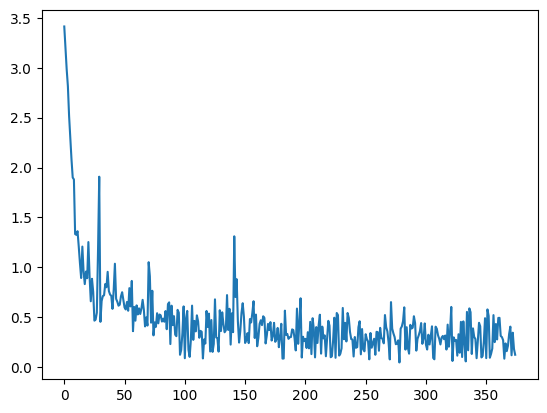

In [27]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [28]:
question, text = 'What is south of the bedroom?','The hallway is south of the garden. The garden is south of the bedroom.'
input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)
start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
print(question, answer.capitalize())

What is south of the bedroom? Garden


In [29]:
from torch.utils.data import DataLoader

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']
train_ds.set_format(type='pt', columns=columns_to_return)
test_ds.set_format(type='pt', columns=columns_to_return)

In [30]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    start_labels = pred.label_ids[0]
    start_preds = pred.predictions[0].argmax(-1)
    end_labels = pred.label_ids[1]
    end_preds = pred.predictions[1].argmax(-1)

    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end = f1_score(end_labels, end_preds, average='macro')

    return {
        'f1_start': f1_start,
        'f1_end': f1_end,
    }

In [31]:
del model

In [32]:
from transformers import DistilBertForQuestionAnswering

pytorch_model = DistilBertForQuestionAnswering.from_pretrained("model/pytorch")

In [33]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='results/',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=20,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=50
)

trainer = Trainer(
    model=pytorch_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
50,1.551200
100,0.896600
150,0.562400
200,0.481200
250,0.399600
300,0.393300
350,0.350300


TrainOutput(global_step=375, training_loss=0.6435019200642904, metrics={'train_runtime': 20.3578, 'train_samples_per_second': 147.363, 'train_steps_per_second': 18.42, 'total_flos': 19904183208000.0, 'train_loss': 0.6435019200642904, 'epoch': 3.0})

In [34]:
trainer.evaluate(test_ds)

{'eval_loss': 0.327355295419693,
 'eval_f1_start': 0.7940603141841533,
 'eval_f1_end': 0.7875102880658437,
 'eval_runtime': 1.3266,
 'eval_samples_per_second': 753.82,
 'eval_steps_per_second': 94.227,
 'epoch': 3.0}

In [35]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pytorch_model.to(device)

question, text = 'What is east of the hallway?','The kitchen is east of the hallway. The garden is south of the bedroom.'

input_dict = tokenizer(text, question, return_tensors='pt')

input_ids = input_dict['input_ids'].to(device)
attention_mask = input_dict['attention_mask'].to(device)

outputs = pytorch_model(input_ids, attention_mask=attention_mask)

start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[torch.argmax(start_logits, 1)[0] : torch.argmax(end_logits, 1)[0]+1])

print(question, answer.capitalize())

What is east of the hallway? Kitchen
